In [17]:
import yaml
import torch

from roadvision3d.src.engine.model_builder import build_model
from roadvision3d.src.engine.model_saver import load_checkpoint
from roadvision3d.tools.inference import inference, process_image
from roadvision3d.src.datasets.object_3d import Calibration
from roadvision3d.visualization import Visualizer

from PIL import Image
import numpy as np

import pickle



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
config_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/configs/MonoLSS_DAIR_150e.yaml'
checkpoint_path = '/home/javier/pytorch/RoadVision3D/work_dirs/MonoLSS_DAIR_150e_valid/logs/checkpoints/checkpoint_epoch_150.pth'

cfg = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = build_model(cfg)
load_checkpoint(model = model,
                optimizer = None,
                filename = checkpoint_path,
                map_location=device)


150

In [19]:
data_id = 0

img_path = '/home/javier/pytorch/RoadVision3D/notebooks/data/calib1.png'

img_tensor, coord = process_image(img_path, cfg)

In [20]:
# Función para cargar un archivo PKL
def cargar_pkl(ruta):
    with open(ruta, 'rb') as archivo:
        return pickle.load(archivo)

calib_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/data/iPhone_16_Pro_calib.pkl'
calib_file = cargar_pkl(calib_path)

print(calib_file)

calib_matrix = calib_file['calib_1']['camera_matrix']

print(calib_matrix)

calib = Calibration.from_intrinsic_matrix(calib_matrix)

{'calib_05': {'camera_matrix': array([[875.87988717,   0.        , 963.17817063],
       [  0.        , 874.94957869, 539.95067275],
       [  0.        ,   0.        ,   1.        ]]), 'dist_calib': array([[-0.03367494,  0.02943681, -0.00026326,  0.00217389, -0.00364975]]), 'undistorted_camera_matrix': array([[872.1669888 ,   0.        , 969.56388662],
       [  0.        , 863.72606215, 539.60829155],
       [  0.        ,   0.        ,   1.        ]])}, 'calib_1': {'camera_matrix': array([[1.61434549e+03, 0.00000000e+00, 9.72495356e+02],
       [0.00000000e+00, 1.61147802e+03, 5.37840876e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'dist_calib': array([[ 0.0963433 ,  0.05252466, -0.00145468,  0.00451231, -0.80605149]]), 'undistorted_camera_matrix': array([[1.53155723e+03, 0.00000000e+00, 1.00063118e+03],
       [0.00000000e+00, 1.49895307e+03, 5.34018597e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}, 'calib_5': {'camera_matrix': array([[7.64186

In [21]:
results = inference(img_tensor, calib, model, cfg, device, coord)

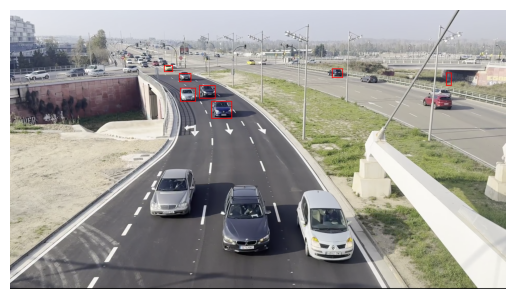

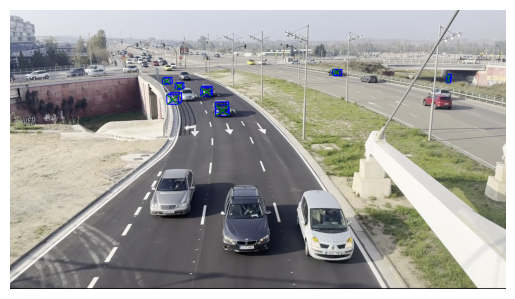

In [22]:
visualizer = Visualizer(calib=calib, pitch=0.22)

img_file = Image.open(img_path)

# Draw 2D bounding boxes on the image
image_with_2d = visualizer.draw_2d_bboxes(img_file, results, color='red', width=3, display=True)

# Draw 3D bounding boxes on the image
image_with_3d = visualizer.draw_3d_bboxes(img_file, results, color='blue', color_front='green', width=4, display=True)